# Kubernets


The goal is to host cloud-native application that must:

- Scale on demand
- Self-heal
- Support zero-downtime rolling updates
- Run anywhere (in cloud or non-cloud, like Raspberry PI) as long Kubernets are installed

Kubernets is an orchestrator that brings together a set of microservices and organizes them into an application that brings value. It also provides and manages cloud-native features such as scaling, self-healing, and updating.

Kubernets emeged in 2014 (from Google) as a way to abstract underlying cloud and server infrastructure. This allowed Kubernetize to commoditize infrastructure making it *"OS of the cloud"*.

- A Kubernetes cluster consists of one or more machines that have Kubernetes installed on them.
- Machines in a Kubernetes cluster are referred to as Nodes, but colloquially there are Master Nodes (Masters) and Worker Nodes (Nodes).
- Nodes run user applications and can either be Linux or Windows Nodes.
- All Nodes run two main services: `kubelet` and Container runtime.
- The `kubelet` is the main Kubernetes agent. It joins the Node to the cluster and communicates with the control plane, in charge of notifying when tasks are received and reporting on the status of those tasks.
- The container runtime starts and stops containers.
- Hosted Kubernetes is where your cloud provider rents you a Kubernetes cluster. Sometimes, it is called Kubernetes as a Service, where we don't have to worry about Masters, just Nodes. There are many hosted Kubernets services: AWS: Elastic Kubernetes Service (EKS), Azure: Azure Kubernetes Service (AKS), DO: Digital Ocean Kubernetes Service (DOKS), GCP: Google Kubernetes Engine (GKE), Linode: Linode Kubernetes Engine (LKE). I'll use LKE here.

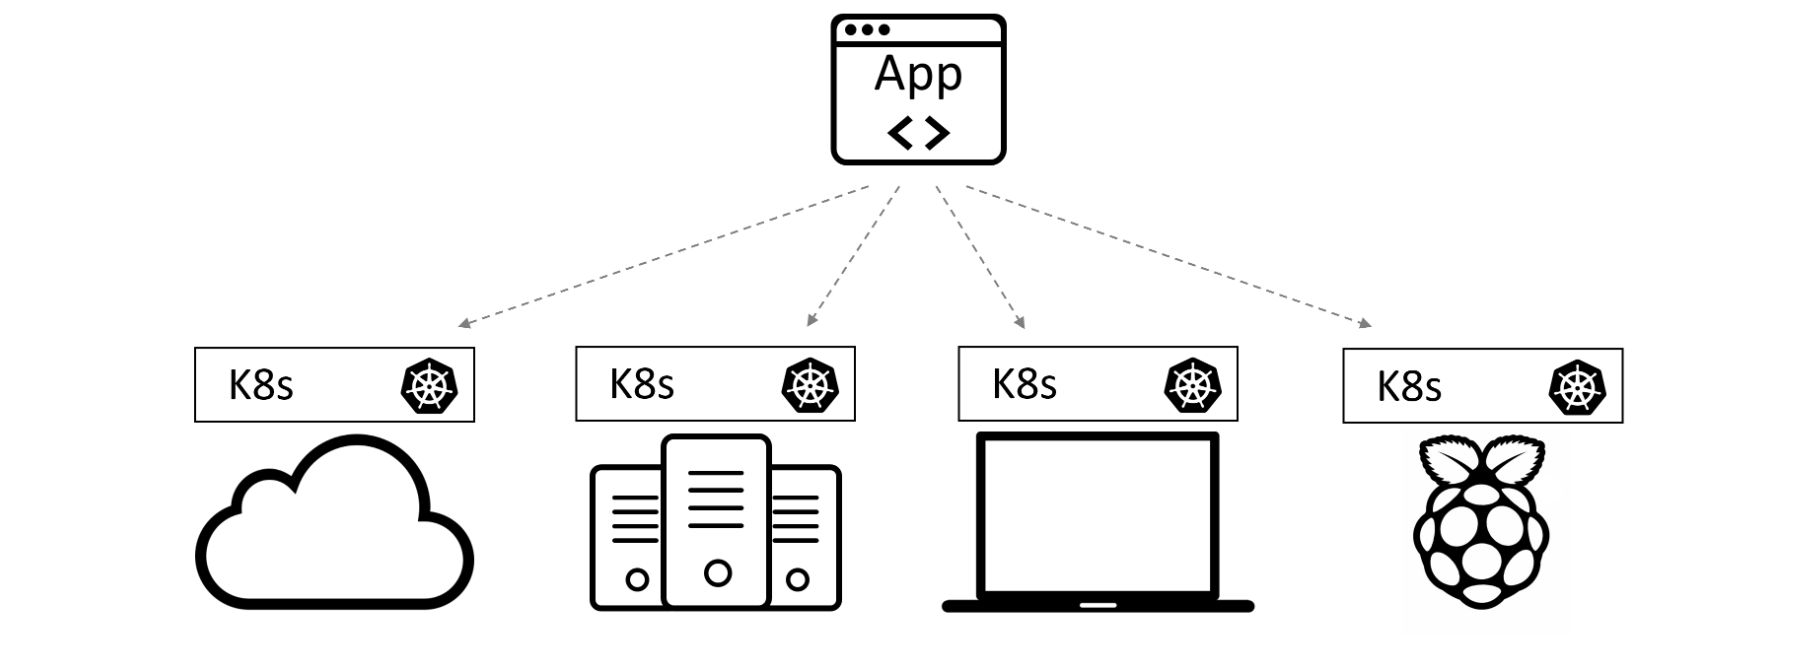

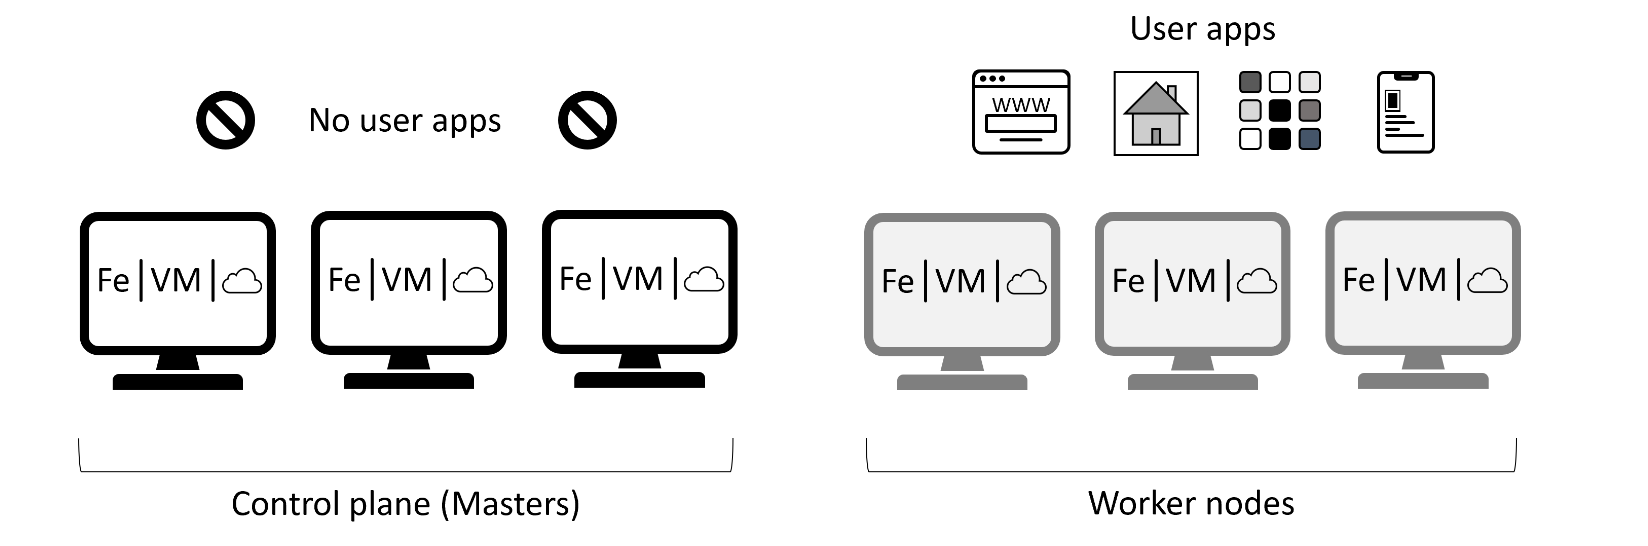

# Containerize an App (via Docker)

First we want our App to be containerized. It has a few files:

In [ ]:
cd /Users/nenad.bozinovic/Work/blog/nbs/mini-projects/10_kubernets/usercode

/Users/nenad.bozinovic/Work/blog/nbs/mini-projects/10_kubernets/usercode


In [ ]:
!ls App

Dockerfile    app.js        bootstrap.css package.json  views


- `Dockerfile`: This file is not part of the application. It contains a list of instructions that Docker executes to create the container image (i.e. containerize the application).
- `app.js`: This is the main application file. It is a Node.js application.
- `bootstrap.css`: This is a stylesheet template, which determines how the application’s web page will look.
- `package.json`: This lists the application dependencies.
- `views`: This is a folder that contains the HTML used to populate the application’s web page.

Docker file contains following:
```
FROM node:current-slim
COPY . /src
RUN cd /src; npm install
EXPOSE 8080
CMD cd /src && node ./app.js
```


In [ ]:
!docker --version

Docker version 20.10.23, build 7155243


We'll now build two docker images called qsk-course version 1.0 and 1.1 under my local account (`nesaboz`):

In [ ]:
#!docker image build -t nesaboz/qsk-course:1.0 App/.

Modify the App to create a new version and build version 1.1:

In [ ]:
#!docker image build -t nesaboz/qsk-course:1.1 .`

We can see the `nesaboz/qsk-course` image now in the list of docker images:

In [ ]:
!docker image ls

REPOSITORY                  TAG       IMAGE ID       CREATED        SIZE
nesaboz/qsk-course          1.0       8d9065c8c75f   2 hours ago    268MB
nesaboz/qsk-course          1.1       60932818191e   5 hours ago    268MB
nesaboz/docker101tutorial   latest    940714c42b63   2 days ago     47MB
alpine/git                  latest    22d84a66cda4   3 months ago   43.6MB


We can now actually run the application locally by running:

In [ ]:
#!docker run -dp 8080 nesaboz/qsk-course:1.0

Docker will assign some port (can be seen in Docker Desktop), and our app will be running locally in a browser:

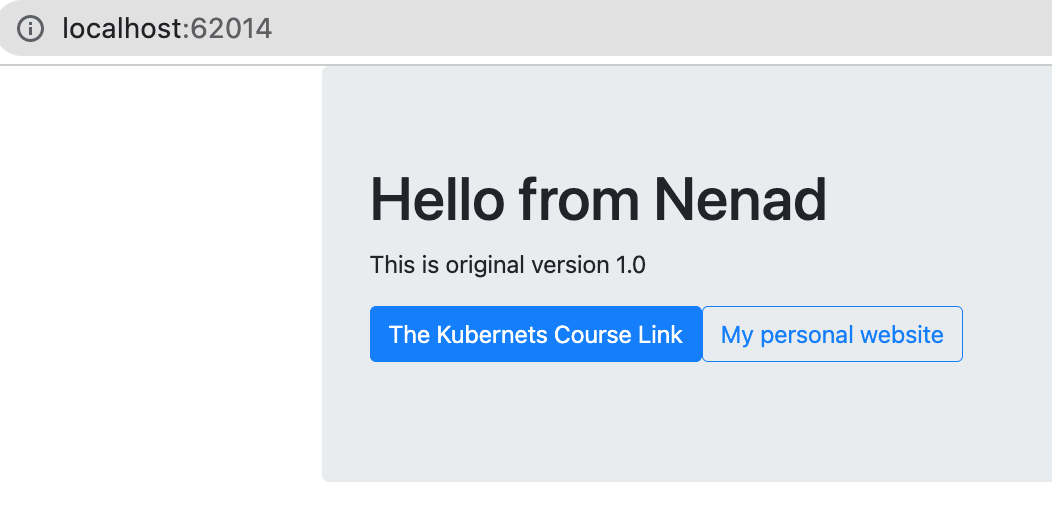

We can also run version 1.1:

In [ ]:
# !docker run -dp 8080 nesaboz/qsk-course:1.1

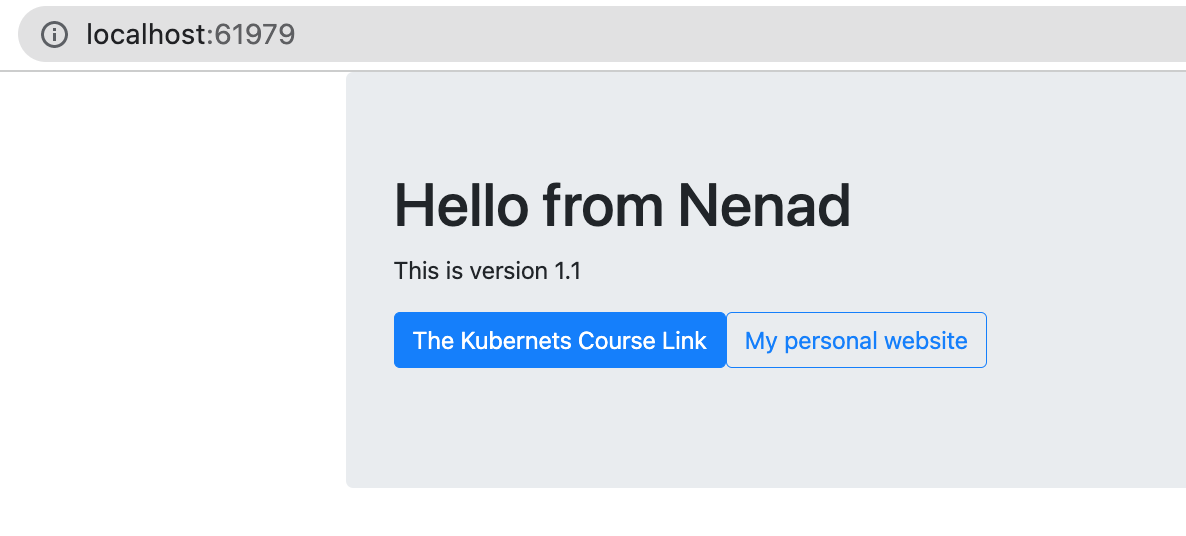

# Register Images (via DockerHub)

Running locally is fine but we want to run in a cloud. There are many hosting services for containers, DockerHub is the easiest to use. We can push container to DockerHub by running the following (in Terminal since it requires password):

```zsh
docker login --username nesaboz
docker image push nesaboz/qsk-course:1.0
```

And we can see now that we have two verions on the [DockerHub](https://hub.docker.com/repository/docker/nesaboz/qsk-course/general):

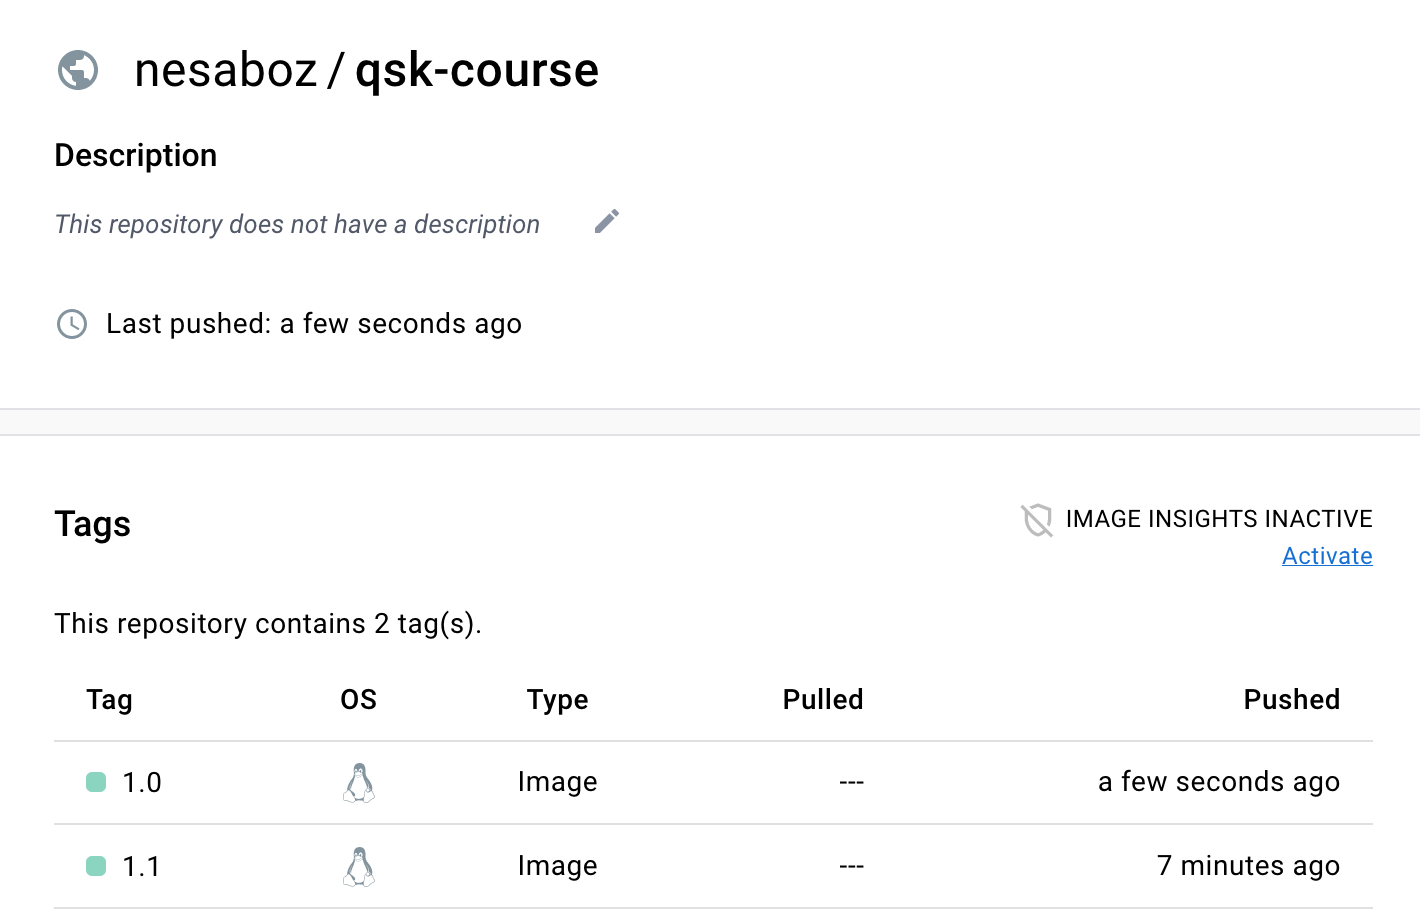

# Set up Hosted Kubernets (via Linode Kubernets Engine aka LKE)

LKE ([https://cloud.linode.com/](https://cloud.linode.com/)) is a paid service to host Kubernets by setting a cluster of machines (we'll use shared, CPU-only VMs). Once we set up a cluster, we can download a config file (aka kubeconfig file) that looks like this:

```
apiVersion: v1
kind: Config
preferences: {}

clusters:
- cluster:
    certificate-authority-data: LS0tLS1CR...
    server: https://8c292154-27de-4e91-a129-fcb2a1614fee.us-west-1.linodelke.net:443
  name: lke95373

users:
- name: lke95373-admin
  user:
    as-user-extra: {}
    token: eyJhbGc...

contexts:
- context:
    cluster: lke95373
    namespace: default
    user: lke95373-admin
  name: lke95373-ctx

current-context: lke95373-ctx
```

# Connect to LKE

We can now activate nodes: 

```zsh
export KUBECONFIG=/usercode/config    <== path might be different, for example KUBECONFIG=config
kubectl get nodes
```

```
NAME                           STATUS   ROLES    AGE   VERSION
lke95373-144188-63fe9e5739a9   Ready    <none>   22h   v1.25.4
lke95373-144188-63fe9e576608   Ready    <none>   22h   v1.25.4
```


The nodes are now running.

# `kubectl`

Main command that executes everything kubernets is `kubectl`:

```zsh
kubectl version -o yaml
```

```text
clientVersion:
  buildDate: "2022-11-09T13:36:36Z"
  compiler: gc
  gitCommit: 872a965c6c6526caa949f0c6ac028ef7aff3fb78
  gitTreeState: clean
  gitVersion: v1.25.4
  goVersion: go1.19.3
  major: "1"
  minor: "25"
  platform: darwin/amd64
kustomizeVersion: v4.5.7
serverVersion:
  buildDate: "2023-01-18T19:15:26Z"
  compiler: gc
  gitCommit: ff2c119726cc1f8926fb0585c74b25921e866a28
  gitTreeState: clean
  gitVersion: v1.25.6
  goVersion: go1.19.5
  major: "1"
  minor: "25"
  platform: linux/amd64
```

# Pod object

Pod is a lightweight wrapper for Docker image we already deployed on DockerHub. The config file for Pod is `pod.yml`:
```
apiVersion: v1
kind: Pod
metadata:
  name: first-pod
  labels:
    project: qsk-course
spec:
  containers:
    - name: web-ctr
      image: nesaboz/qsk-course:1.0
      ports:
        - containerPort: 8080
```

```zsh
kubectl apply -f pod.yml
kubectl get pods
```

```text
NAME        READY   STATUS    RESTARTS   AGE
first-pod   1/1     Running   0          3m36s
```

We can run similar though more detailed command (doesn't run here in notebook):

```zsh
kubectl describe pod first-pod
```

To delete pods:

```zsh
kubectl delete pod first-pod
kubectl delete --all pods
```

# Kubernets Service controller

Service controller provides connectivity to the application running in the Pod i.e. provisions an internet-facing load balancer. To do that we use `svc-cloud.yml` file that contains following:

```
apiVersion: v1
kind: Service
metadata:
  name: cloud-lb
spec:
  type: LoadBalancer
  ports:
  - port: 8080
    targetPort: 8080
  selector:
    project: qsk-course    <- this name must match pod.metadata.labels.project above
```

**Note that `spec.selector.project` must match the `pod.metadata.labels.project`**

(We also have an option of running `svc-local.yml` skipping that for now)


```zsh
kubectl apply -f svc-cloud.yml   #  service/cloud-lb created`
kubectl get svc
```
```
qsk-cloud    LoadBalancer   10.128.141.64   45.79.230.110   8080:32026/TCP   13s
```

or for more details run:
```zsh
kubectl describe svc cloud-lb
```
now go to the `45.79.230.110:8080` address in your browser:


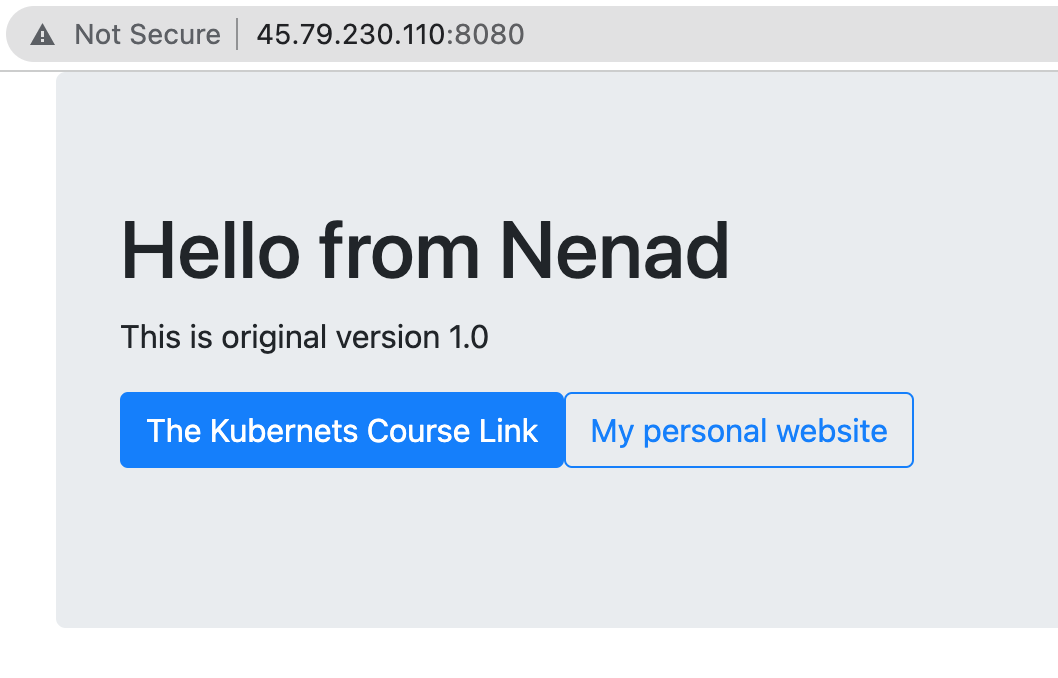


To delete svc object:

```zsh
kubectl delete svc cloud-lb
```

# Kubernets Deployment controller

Deployment service provides self-healing, enable scaling, and rolling updates. The file `deploy.yml` looks like this:

```
kind: Deployment                   <<== Type of object being defined
apiVersion: apps/v1                <<== Version of object specification
metadata:
  name: qsk-deploy
spec:
  replicas: 5                      <<== How many Pod replicas
  selector:
    matchLabels:                   <<== Tells the Deployment controller
      project: qsk-course            <<== which Pods to manage, must match svc.spec.selector.project above
  template:
    metadata:
      labels:
        project: qsk-course          <<== Pod label, must match svc.spec.selector.project above
    spec:
      containers:
      - name: qsk-pod
        imagePullPolicy: Always           <<== Never use local images
        ports:
        - containerPort: 8080             <<== Network port
        image: nesaboz/qsk-course:1.0     <<== Image containing the app
```


**Note that `spec.template.labels.project` must match the `svc.spec.selector.project`**

```zsh
kubectl apply -f deploy.yml
kubectl get deployments
```

```
NAME         READY   UP-TO-DATE   AVAILABLE   AGE
qsk-deploy   3/5     5            3           3s
```

```zsh
kubectl get pods
```

```text
NAME                          READY   STATUS    RESTARTS   AGE
qsk-deploy-767d99b5c7-5v9vs   1/1     Running   0          52s
qsk-deploy-767d99b5c7-9h67b   1/1     Running   0          52s
qsk-deploy-767d99b5c7-dpsk9   1/1     Running   0          52s
qsk-deploy-767d99b5c7-lwxcf   1/1     Running   0          52s
qsk-deploy-767d99b5c7-wh2rh   1/1     Running   0          52s
```

If we delete one pod, for example first one `qsk-deploy-767d99b5c7-5v9vs`:

```zsh
kubectl delete pod qsk-deploy-767d99b5c7-5v9vs
kubectl get pods
```

```text
NAME                          READY   STATUS        RESTARTS   AGE
qsk-deploy-767d99b5c7-4vdjs   1/1     Running       0          13s
qsk-deploy-767d99b5c7-5v9vs   1/1     Terminating   0          3m19s
qsk-deploy-767d99b5c7-9h67b   1/1     Running       0          3m19s
qsk-deploy-767d99b5c7-dpsk9   1/1     Running       0          3m19s
qsk-deploy-767d99b5c7-lwxcf   1/1     Running       0          3m19s
qsk-deploy-767d99b5c7-wh2rh   1/1     Running       0          3m19s
```

we see that new one gets running immediately, demonstrating self-healing.

We can also see that pods are running on both nodes (`lke...a9` and `lke...08`):

```zsh
$kubectl get pods -o wide
```

```text
NAME                          READY   STATUS    RESTARTS   AGE     IP         NODE                           NOMINATED NODE   READINESS GATES
qsk-deploy-767d99b5c7-4vdjs   1/1     Running   0          2m50s   10.2.1.7   lke95373-144188-63fe9e5739a9   <none>           <none>
qsk-deploy-767d99b5c7-9h67b   1/1     Running   0          5m56s   10.2.0.7   lke95373-144188-63fe9e576608   <none>           <none>
qsk-deploy-767d99b5c7-dpsk9   1/1     Running   0          5m56s   10.2.1.6   lke95373-144188-63fe9e5739a9   <none>           <none>
qsk-deploy-767d99b5c7-lwxcf   1/1     Running   0          5m56s   10.2.1.4   lke95373-144188-63fe9e5739a9   <none>           <none>
qsk-deploy-767d99b5c7-wh2rh   1/1     Running   0          5m56s   10.2.0.6   lke95373-144188-63fe9e576608   <none>           <none>

```

 If we delete a node (in a LKE Cloud Console) then we can see that new pods will be created on a available node:

```zsh
kubectl get nodes
```

```text
NAME                           STATUS   ROLES    AGE   VERSION
lke95373-144188-63fe9e576608   Ready    <none>   23h   v1.25.4
```

```zsh
kubectl get pods -o wide
```

```text
NAME                          READY   STATUS    RESTARTS   AGE    IP          NODE                           NOMINATED NODE   READINESS GATES
qsk-deploy-767d99b5c7-2qmgn   1/1     Running   0          105s   10.2.0.8    lke95373-144188-63fe9e576608   <none>           <none>
qsk-deploy-767d99b5c7-9h67b   1/1     Running   0          13m    10.2.0.7    lke95373-144188-63fe9e576608   <none>           <none>
qsk-deploy-767d99b5c7-f6k76   1/1     Running   0          104s   10.2.0.10   lke95373-144188-63fe9e576608   <none>           <none>
qsk-deploy-767d99b5c7-vsvgv   1/1     Running   0          104s   10.2.0.9    lke95373-144188-63fe9e576608   <none>           <none>
qsk-deploy-767d99b5c7-wh2rh   1/1     Running   0          13m    10.2.0.6    lke95373-144188-63fe9e576608   <none>           <none>
```

We can see that old pods (`qsk-deploy...9h67b` and `qsk-deploy...wh2rh`) are still running, the other 3 are new (created 105 seconds ago). If we had set the Autoscale Pool on LKE, then the node will recover eventually:

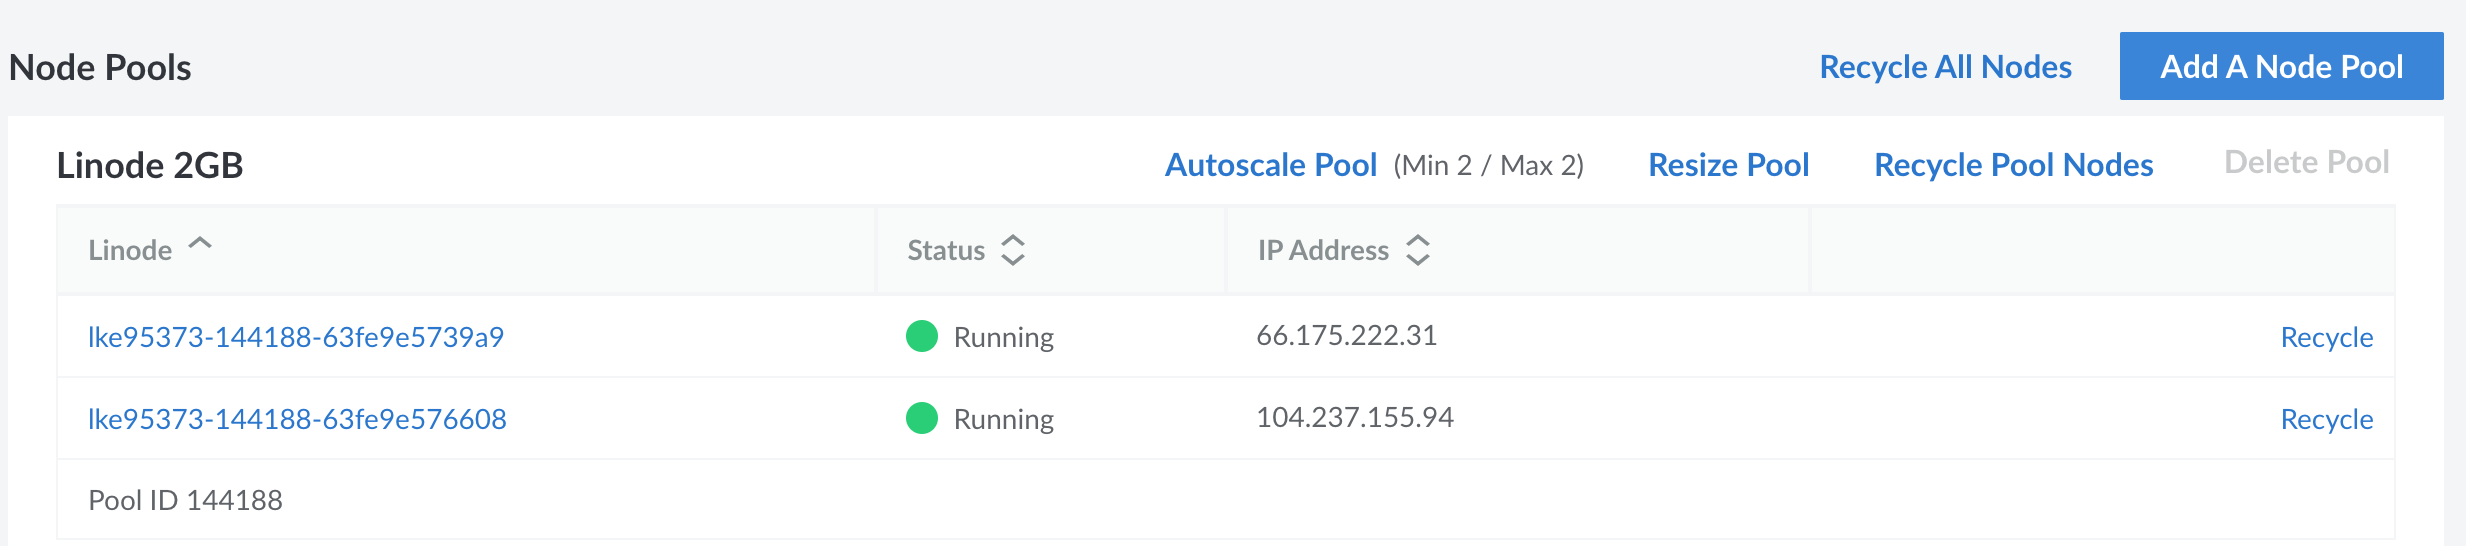

but the pods will still run only on one (`lke...08`) node:

```
NAME                          READY   STATUS    RESTARTS   AGE   IP          NODE                           NOMINATED NODE   READINESS GATES
qsk-deploy-767d99b5c7-2qmgn   1/1     Running   0          20m   10.2.0.8    lke95373-144188-63fe9e576608   <none>           <none>
qsk-deploy-767d99b5c7-9h67b   1/1     Running   0          32m   10.2.0.7    lke95373-144188-63fe9e576608   <none>           <none>
qsk-deploy-767d99b5c7-f6k76   1/1     Running   0          20m   10.2.0.10   lke95373-144188-63fe9e576608   <none>           <none>
qsk-deploy-767d99b5c7-vsvgv   1/1     Running   0          20m   10.2.0.9    lke95373-144188-63fe9e576608   <none>           <none>
qsk-deploy-767d99b5c7-wh2rh   1/1     Running   0          32m   10.2.0.6    lke95373-144188-63fe9e576608   <none>           <none>
```

If we change a number of replicas in the deployment file, newly pods will intelligently run on a newly recovered node so the distribution is maintained:

```zsh
kubectl scale --replicas 10 deployment/qsk-deploy
kubectl get pods -o wide
```

```text
NAME                          READY   STATUS    RESTARTS   AGE    IP          NODE                           NOMINATED NODE   READINESS GATES
qsk-deploy-679dc78b78-bgmfm   1/1     Running   0          14m    10.2.0.3    lke95373-144188-63fe9e5739a9   <none>           <none>
qsk-deploy-679dc78b78-ckvqx   1/1     Running   0          14m    10.2.0.5    lke95373-144188-63fe9e5739a9   <none>           <none>
qsk-deploy-679dc78b78-cvh5t   1/1     Running   0          2m6s   10.2.1.2    lke95373-144188-63fe9e576608   <none>           <none>
qsk-deploy-679dc78b78-gll5p   1/1     Running   0          2m6s   10.2.1.6    lke95373-144188-63fe9e576608   <none>           <none>
qsk-deploy-679dc78b78-hjsqx   1/1     Running   0          14m    10.2.0.6    lke95373-144188-63fe9e5739a9   <none>           <none>
qsk-deploy-679dc78b78-qs4gs   1/1     Running   0          14m    10.2.0.10   lke95373-144188-63fe9e5739a9   <none>           <none>
qsk-deploy-679dc78b78-r4kgl   1/1     Running   0          2m6s   10.2.1.5    lke95373-144188-63fe9e576608   <none>           <none>
qsk-deploy-679dc78b78-rqpgh   1/1     Running   0          2m6s   10.2.1.4    lke95373-144188-63fe9e576608   <none>           <none>
qsk-deploy-679dc78b78-vblz4   1/1     Running   0          14m    10.2.0.4    lke95373-144188-63fe9e5739a9   <none>           <none>
qsk-deploy-679dc78b78-x6f2g   1/1     Running   0          2m6s   10.2.1.3    lke95373-144188-63fe9e576608   <none>           <none>
```

**Note: `kubectl scale` should not be used since there is a discrpancy between `deploy.yml` and new nubmer of replicas. The common practice is to always edit `deploy.yml` file and re-apply.**

# Rolling update

We can apply rolling update if we add following lines to `deploy.yml`:

```
  minReadySeconds: 20        <== to wait for 20 seconds after updating each replica
  strategy:                  
    type: RollingUpdate      
    rollingUpdate:           
      maxSurge: 1         <== allows Kubernetes to add one extra Pod during an update operation
      maxUnavailable: 0   <== prevents Kubernetes from reducing the number of Pods during an update
```      

as well as update the version of the image:
```
image: nesaboz/qsk-course:1.1      <== this version must exists as an container on DockerHub
```

so the `deploy.yml` looks like this:

```
apiVersion: apps/v1
kind: Deployment
metadata:
  name: qsk-deploy
spec:
  replicas: 5
  selector:
    matchLabels:
      project: diy
  minReadySeconds: 20        
  strategy:                  
    type: RollingUpdate      
    rollingUpdate:           
      maxSurge: 1            
      maxUnavailable: 0
  template:
    metadata:
      labels:
        project: diy
    spec: 
      containers:
      - name: qsk-pod
        imagePullPolicy: Always
        ports:
        - containerPort: 8080
        image: nesaboz/qsk-course:1.1 
```

Now if we re-apply deployment:

```zsh
kubectl apply -f deploy.yml
```

```
deployment.apps/qsk-deploy configured
```

we can monitor the rollout status:

```zsh
kubectl rollout status deployment qsk-deploy
```

```text
Waiting for deployment "qsk-deploy" rollout to finish: 1 out of 5 new replicas have been updated...
Waiting for deployment "qsk-deploy" rollout to finish: 1 out of 5 new replicas have been updated...
Waiting for deployment "qsk-deploy" rollout to finish: 1 out of 5 new replicas have been updated...
Waiting for deployment "qsk-deploy" rollout to finish: 1 out of 5 new replicas have been updated...
Waiting for deployment "qsk-deploy" rollout to finish: 2 out of 5 new replicas have been updated...
Waiting for deployment "qsk-deploy" rollout to finish: 2 out of 5 new replicas have been updated...
Waiting for deployment "qsk-deploy" rollout to finish: 2 out of 5 new replicas have been updated...
Waiting for deployment "qsk-deploy" rollout to finish: 3 out of 5 new replicas have been updated...
Waiting for deployment "qsk-deploy" rollout to finish: 3 out of 5 new replicas have been updated...
Waiting for deployment "qsk-deploy" rollout to finish: 3 out of 5 new replicas have been updated...
Waiting for deployment "qsk-deploy" rollout to finish: 3 out of 5 new replicas have been updated...
Waiting for deployment "qsk-deploy" rollout to finish: 4 out of 5 new replicas have been updated...
Waiting for deployment "qsk-deploy" rollout to finish: 4 out of 5 new replicas have been updated...
Waiting for deployment "qsk-deploy" rollout to finish: 4 out of 5 new replicas have been updated...
Waiting for deployment "qsk-deploy" rollout to finish: 4 out of 5 new replicas have been updated...
Waiting for deployment "qsk-deploy" rollout to finish: 1 old replicas are pending termination...
Waiting for deployment "qsk-deploy" rollout to finish: 1 old replicas are pending termination...
Waiting for deployment "qsk-deploy" rollout to finish: 1 old replicas are pending termination...
deployment "qsk-deploy" successfully rolled out
```

Soon, the App will be updated: 

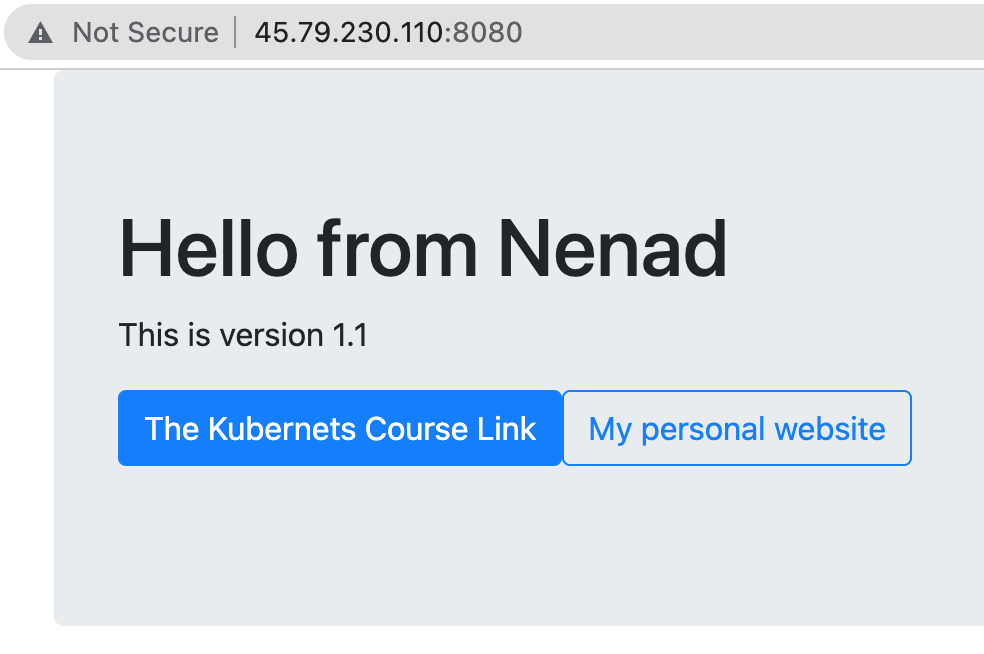

# Appendix: Apply service locally

For local application let's use local `scv-local.yml` file:

```
apiVersion: v1
kind: Service
metadata:
  name: svc-local
spec:
  type: NodePort    <== this was LoadBalancer for cloud servers, now is NodePort
  ports:
  - port: 8080
    protocol: TCP       <== this is a new line
    targetPort: 8080
    nodePort: 31111     <== this is a new line
  selector:
    project: qsk-course    <== this must match with the pod project
```